# Coursera 
## Applied data science capstone
### Week 5: Data exploitation


# PROBLEM DEFINITION

A Taxy company wants to set up its business in Milano city, Italy. The business idea is to be affiliated with all the Hotels in the radius of 2 km from the city center so as to exploit their smart mobility transport service solutions. They want to offer the fastest pick up service to be as effective and fast as possible. For this reason they are looking for the perfect positioning for their headquartier. The goal is to find the place that minimize the average distance from all the Hotels in the very citycenter. Assuming an average speed of 10 km per hour to move in the city (indeed a conservative value (https://www.statista.com/statistics/264703/average-speed-in-europes-15-most-congested-cities/) and neglecting all mobility restrictions and all traffic congestion issues we want to define an estimation time for a taxi service to reach each Hotel also.

In [97]:
# Import package
import folium

# Define coordinates
Latitude = 45.465586
Longitude = 9.185944
# Create map of Milano 
MilanoMap = folium.Map(location=[Latitude, Longitude], zoom_start=13.5)
MilanoMap

# Data collection
We make use of data retrived through Fouresquare API  to get the cooridnates for every hotel (https://developer.foursquare.com/developer/). We request results having the tag 'Hotel' in the Foursquare API and located within a radius of 1500 meters from Cordusio square (https://en.wikipedia.org/wiki/Piazza_Cordusio), this distance is representative of the restricted-traffic zone of the city, the center decimal coordinates are Latitude = 45.465586 and Longitude = 9.185944. Notice that using a free developer account of Foursquare we retrive up to 100 places only so using the 'query' tag is particularly useful in since we have not to filter every type of venues. This provides us a list of 100 Hotels in the area with their coordinates as shown in the next table where the first 10 results are shown. Finally we can depict all the Hotels on the Milano city map, we also draw the circle defining the considered urban area.


In [99]:
# Import Packages
import requests
from pandas import json_normalize

# Set Foursquare API
CLIENT_ID = '02QBHIMZSD0O05JYQX4MBB0KOZR1KH3V2TQ34PV0CH1FKBEU' 
CLIENT_SECRET = 'NNGC5E03TOWAXLIWW1ERT03PH5T3YFFN1124KLOM31F5AE44'
VERSION = '20180605' 
LIMIT = 1000 
RADIUS = 2000
QUERY = ['Hotel'] 

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Latitude, 
    Longitude,  
    RADIUS, 
    LIMIT,
    QUERY
)
# get results
results = requests.get(url).json()
# Extract venues information
venues = results['response']['groups'][0]['items']
# flatten JSON format
venues = json_normalize(venues) 
# filter columns 
venues = venues.loc[:, ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
# filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis=1)
# clean columns
venues.columns = [col.split(".")[-1] for col in venues.columns]
# Define hotels dataframe
MilanoHotel = venues
# Print results
print('There are',MilanoHotel.shape[0],'Hotels in the area')
# Print results
MilanoHotel.head(10)

There are 100 Hotels in the area


,name,categories,lat,lng
0,Park Hyatt Milan,Hotel,45.465532,9.188911
1,Room Mate Giulia Hotel,Hotel,45.465250,9.189396
2,BVLGARI Hotel Milano,Hotel,45.470149,9.189318
3,Mandarin Oriental,Hotel,45.469461,9.190876
4,Armani Hotel Milano,Hotel,45.470478,9.192882
5,Four Seasons Hotel Milano,Hotel,45.469372,9.195466
6,Starhotels Rosa Grand,Hotel,45.464122,9.193692
7,The Square,Hotel,45.461003,9.189338
8,HMS Hotel Milano Scala,Hotel,45.469061,9.186865
9,Palazzo Parigi,Hotel,45.473378,9.191108


In [100]:
for idx in MilanoHotel.index :
    folium.CircleMarker(
        [MilanoHotel.iloc[idx,2], MilanoHotel.iloc[idx,3]],
        radius=5,
        color = 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(MilanoMap)  

folium.Circle(
        [Latitude, Longitude],
        radius=RADIUS,
        color = 'red',
        fill=False,
        parse_html=False).add_to(MilanoMap) 

MilanoMap

# USING OUR DATA: Metodology
We want to use the data to define the best location for the headquartier. Lets $x$ and $y$ be our the Headquartier coordianates, and lets $H_x^i$ and $H_y^i$ the coordinates of each Hotel $i$.
We can express the average distance $d$ using the formula
$$ d=\frac{1}{N}\sum_i^N\sqrt{(x-H_x^i)^2+(y-H_y^i)^2} $$
We can use an operational resarch approach to find the optimal solution for the minimization problem of finding the Headquartier coordinates x and y so as that d is minimized. We can do it in Python using it Scipy libraries to numerically solve the problem.

Optimization terminated successfully.
The optimal position coordinates are [45.46756174  9.19235717]
The minimum average distance is 1102.48 meters
The centered average distance is 1262.73 meters
The minimum average travelling time @10km/h is 7.0 minutes
The maximum distance is 2628.9 meters
The minimum distance is 160.11 meters


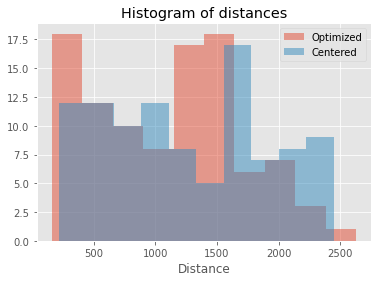

In [101]:
# Import the packages
import numpy as np
from scipy.optimize import minimize

# Define the distance function
def MapDistance(x,H):
    # c is a coefficent that converts coordinates into meters 
    c = 100000;
    return np.sum(np.sqrt(np.sum(np.square((x-H)*c),axis=1)))/H.shape[0]

# Define the array of coordinates of every hotel
H = MilanoHotel[['lat','lng']].to_numpy()
# Define an guess initial position as the very center
x0 = np.array([Latitude, Longitude])
# Solve the minimization problem
res = minimize(MapDistance, x0, H, method = 'Nelder-Mead')

# Retrive every distance
MilanoHotel['distance'] = 0
MilanoHotel['distanceC'] = 0
for idx in MilanoHotel.index:
   # To overcome the fact that np.sum does not work on one dimension we have to hack the function call.
   h = np.array([res.x, H[idx]])
   h0 = np.array([x0, H[idx]])
   MilanoHotel.iloc[idx,4] = np.round(MapDistance(res.x,h)*2,2)
   MilanoHotel.iloc[idx,5] = np.round(MapDistance(x0,h0)*2,2)

# Print results
print(res.message)
print('The optimal position coordinates are',res.x)
print('The minimum average distance is',np.round(MapDistance(res.x,H),2),'meters')
print('The centered average distance is',np.round(MapDistance(x0,H),2),'meters')
print('The minimum average travelling time @10km/h is',np.round(MapDistance(res.x,H)/1000/10*60,0),'minutes')
print('The maximum distance is', np.max(MilanoHotel['distance']), 'meters')
print('The minimum distance is', np.min(MilanoHotel['distance']), 'meters')
# Print the distances 

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(MilanoHotel['distance'], alpha=0.5, label='Optimized', bins = 10)
plt.hist(MilanoHotel['distanceC'],alpha=0.5, label='Centered', bins = 10)
plt.legend(loc='upper right')
plt.xlabel('Distance')
plt.title('Histogram of distances')
plt.show()

In [91]:
folium.CircleMarker(
        res.x,
        radius=5,
        color = 'red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(MilanoMap)  

folium.CircleMarker(
        x0,
        radius=5,
        color = 'green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(MilanoMap)  
MilanoMap

# CONCLUSIONS
We notice that for the optimized case the mass of the histogram is more concentrated around the average value, with a spike on the left (i.e. closer positions) and that it presents a lighter right tail. Numerically, the optimized placement allows an average distance of about 200 meter less in respect to the geographical center. Though this may seem negligible it may be not while considering a consistent amount of calls.

The best place to set a fast taxi service for hotels in Milano city center is not in the real center of the city. The result is not surprising, we can see from the map that the hotels are located in the north-west and the center area, hovewer this conclusion is more solid when supported by data. In a more precise study one should take into account road distance instead of geographical distances, traffic limitations and congestion should be considered too. Another important thing one could consider is the number of calls each hotel makes in order to weight their importance: the latter implementation is straightforward by adding a weighting coefficient $W_i$ to the formula to represent the number of calls associated to each hotel. 
$$ d=\frac{1}{N}\sum_i^NW_i\sqrt{(x-H_x^i)^2+(y-H_y^i)^2} $$

t has been shown that is possible to use data and python to solve a  particular problem that won’t be easly solved differently. In this case we used hotel location coordinates to get conclusions about the optimal positioning of a shared service. The same approach can be used for more particular use cases and can be more and more effective the more rich data one can use. Machine learning techniques can be used to derive conclusions and optimization can be used to get numerical results out of cumbersome problems.